In [1]:
# Codeblock 1
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Codeblock 2
SCALE = 3
PAPER_W = 210 * SCALE
PAPER_H = 297 * SCALE

In [3]:
# Codeblock 3
def load_image(path, scale=0.7):
    img = cv2.imread(path)
    img_resized = cv2.resize(img, (0,0), None, scale, scale)
    return img_resized

def show_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6,8))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    plt.show()

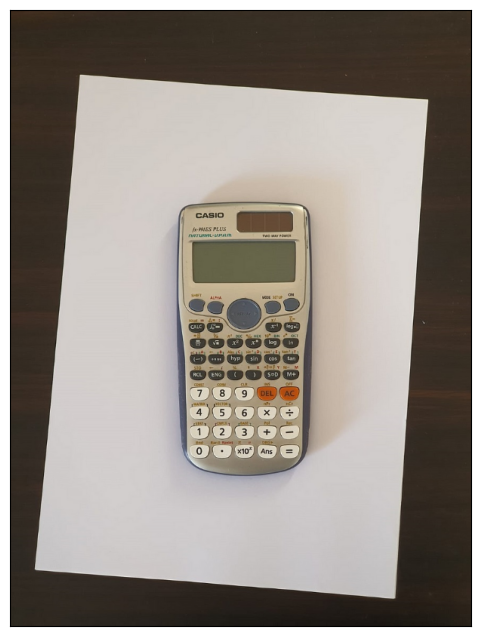

(817, 612, 3)


In [ ]:
# Codeblock 4
img_original = load_image(path='images/1.jpeg')
show_image(img_original)
print(img_original.shape)

In [5]:
# Codeblock 5
def preprocess_image(img, thresh_1=57, thresh_2=232):
    img_gray  = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)      #1
    img_blur  = cv2.GaussianBlur(img_gray, (5,5), 1)       #2
    img_canny = cv2.Canny(img_blur, thresh_1, thresh_2)    #3
    
    kernel = np.ones((3,3))    #4
    img_dilated = cv2.dilate(img_canny, kernel, iterations=1)    #5
    img_closed = cv2.morphologyEx(img_dilated, cv2.MORPH_CLOSE, 
                                  kernel, iterations=4)          #6
    
    img_preprocessed = img_closed.copy()
    
    img_each_step = {'img_dilated': img_dilated, 
                     'img_canny'  : img_canny, 
                     'img_blur'   : img_blur, 
                     'img_gray'   : img_gray}
    
    return img_preprocessed, img_each_step

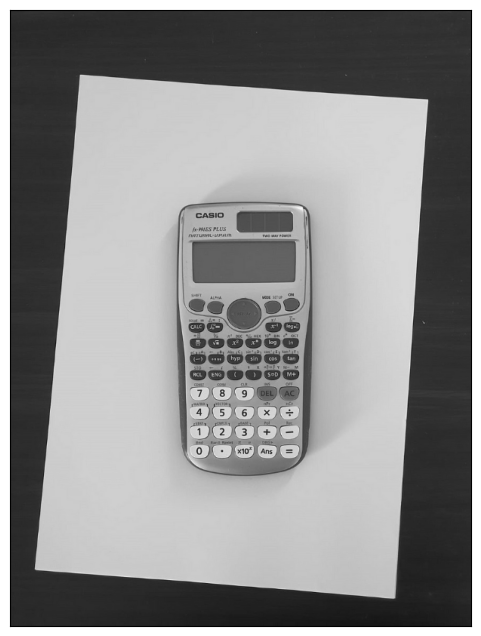

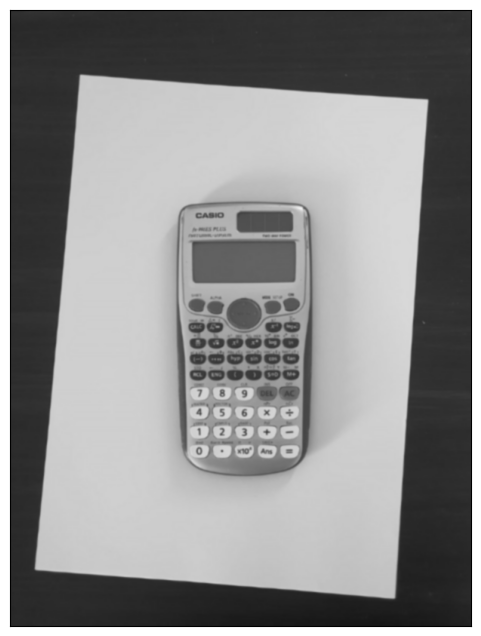

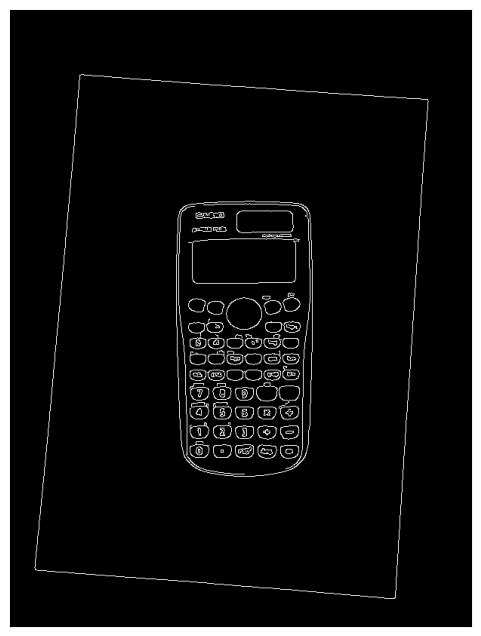

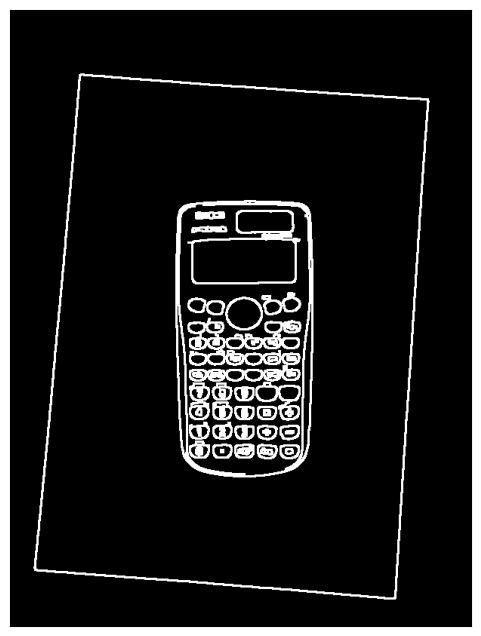

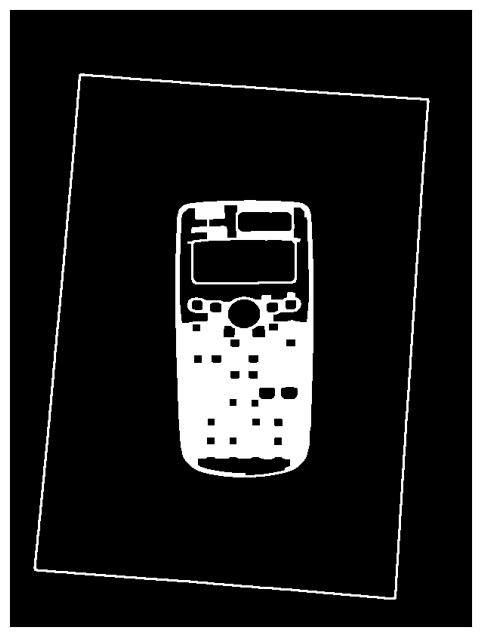

In [21]:
# Codeblock 6
img_preprocessed, img_each_step = preprocess_image(img_original)
show_image(img_each_step['img_gray'])
show_image(img_each_step['img_blur'])
show_image(img_each_step['img_canny'])
show_image(img_each_step['img_dilated'])
show_image(img_preprocessed)

In [7]:
# Codeblock 7
def find_contours(img_preprocessed, img_original, epsilon_param=0.04):
    contours, hierarchy = cv2.findContours(image=img_preprocessed, 
                                           mode=cv2.RETR_EXTERNAL, 
                                           method=cv2.CHAIN_APPROX_NONE)  #1
    
    img_contour = img_original.copy()
    cv2.drawContours(img_contour, contours, -1, (203,192,255), 6)  #2
    
    polygons = []
    for contour in contours:
        epsilon = epsilon_param * cv2.arcLength(curve=contour, 
                                                closed=True)  #3
        polygon = cv2.approxPolyDP(curve=contour, 
                                   epsilon=epsilon, closed=True)  #4

        polygon = polygon.reshape(4, 2)  #5
        polygons.append(polygon)
        
        for point in polygon:    
            img_contour = cv2.circle(img=img_contour, center=point, 
                                     radius=8, color=(0,240,0), 
                                     thickness=-1)  #6
    
    return polygons, img_contour

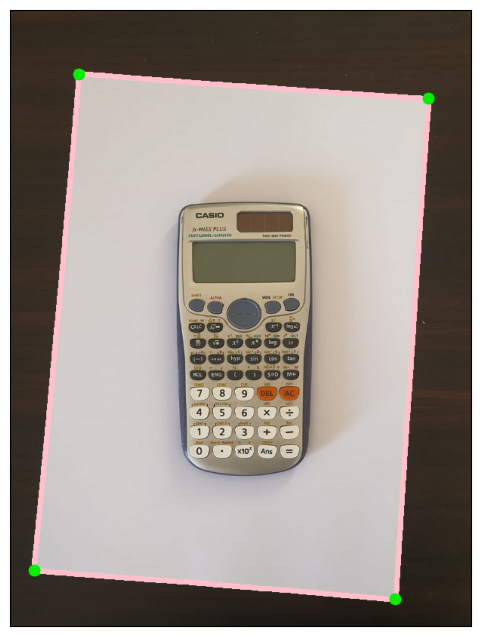

array([[ 91,  85],
       [ 32, 743],
       [510, 781],
       [554, 117]], dtype=int32)

In [22]:
# Codeblock 8
polygons, img_contours = find_contours(img_preprocessed, 
                                       img_original,
                                       epsilon_param=0.04)
show_image(img_contours)
polygons[0]

In [24]:
# Codeblock 9
def reorder_coords(polygon):
    rect_coords = np.zeros((4, 2))

    add = polygon.sum(axis=1)
    rect_coords[0] = polygon[np.argmin(add)]    # Top left
    rect_coords[3] = polygon[np.argmax(add)]    # Bottom right

    subtract = np.diff(polygon, axis=1)
    rect_coords[1] = polygon[np.argmin(subtract)]    # Top right
    rect_coords[2] = polygon[np.argmax(subtract)]    # Bottom left
    
    return rect_coords

In [25]:
# Codeblock 10
rect_coords = np.float32(reorder_coords(polygons[0]))
rect_coords

array([[ 91.,  85.],
       [554., 117.],
       [ 32., 743.],
       [510., 781.]], dtype=float32)

In [26]:
# Codeblock 11
paper_coords = np.float32([[0,0],                # Top left
                           [PAPER_W,0],          # Top right
                           [0,PAPER_H],          # Bottom left
                           [PAPER_W,PAPER_H]])   # Bottom right
paper_coords

array([[  0.,   0.],
       [630.,   0.],
       [  0., 891.],
       [630., 891.]], dtype=float32)

In [27]:
# Codeblock 12
def warp_image(rect_coords, paper_coords, img_original, pad=5):

    matrix = cv2.getPerspectiveTransform(src=rect_coords, 
                                         dst=paper_coords)   #1
    img_warped = cv2.warpPerspective(img_original, matrix,
                                      (PAPER_W, PAPER_H))    #2

    warped_h = img_warped.shape[0]
    warped_w = img_warped.shape[1]
    img_warped = img_warped[pad:warped_h-pad, pad:warped_w-pad]  #3

    return img_warped

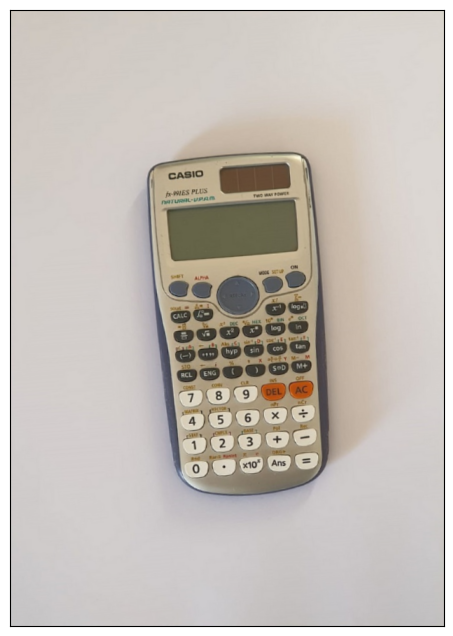

(881, 620, 3)


In [28]:
# Codeblock 13
img_warped = warp_image(rect_coords, paper_coords, img_original)
show_image(img_warped)
print(img_warped.shape)

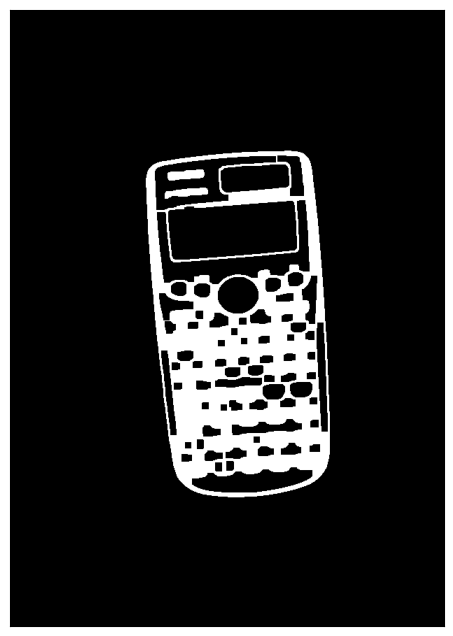

In [29]:
# Codeblock 14
img_warped_preprocessed, _ = preprocess_image(img_warped)
show_image(img_warped_preprocessed)

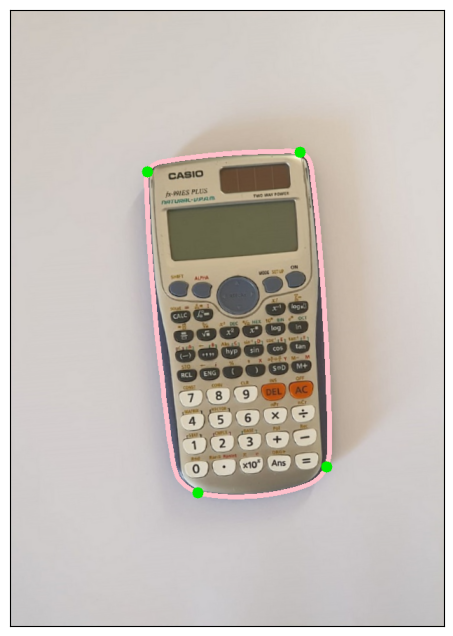

array([[414, 203],
       [196, 231],
       [268, 690],
       [452, 653]], dtype=int32)

In [30]:
# Codeblock 15
polygons_warped, img_contours_warped = find_contours(img_warped_preprocessed, 
                                                     img_warped,
                                                     epsilon_param=0.04)
show_image(img_contours_warped)
polygons_warped[0]

In [31]:
# Codeblock 16
def calculate_sizes(polygons_warped):
    
    rect_coords_list = []
    for polygon in polygons_warped:
        rect_coords = np.float32(reorder_coords(polygon))  #1
        rect_coords_list.append(rect_coords)
    
    heights = []
    widths  = []
    for rect_coords in rect_coords_list:
        height = cv2.norm(rect_coords[0], rect_coords[2], cv2.NORM_L2)  #2
        width  = cv2.norm(rect_coords[0], rect_coords[1], cv2.NORM_L2)  #3
        
        heights.append(height)
        widths.append(width)
    
    heights = np.array(heights).reshape(-1,1)
    widths  = np.array(widths).reshape(-1,1)
    
    sizes = np.hstack((heights, widths))  #4
        
    return sizes, rect_coords_list

sizes, rect_coords_list = calculate_sizes(polygons_warped)
sizes

array([[464.61274197, 219.79080963]])

In [32]:
# Codeblock 17
def convert_to_mm(sizes_pixel, img_warped):
    warped_h = img_warped.shape[0]
    warped_w = img_warped.shape[1]
    
    scale_h = PAPER_H / warped_h    #1
    scale_w = PAPER_W / warped_w    #2
    
    sizes_mm = []
    
    for size_pixel_h, size_pixel_w in sizes_pixel:
        size_mm_h = size_pixel_h * scale_h / SCALE    #3
        size_mm_w = size_pixel_w * scale_w / SCALE    #4
        
        sizes_mm.append([size_mm_h, size_mm_w])
    
    return np.array(sizes_mm)

sizes_mm = convert_to_mm(sizes, img_warped)
sizes_mm

array([[156.62881313,  74.44527423]])

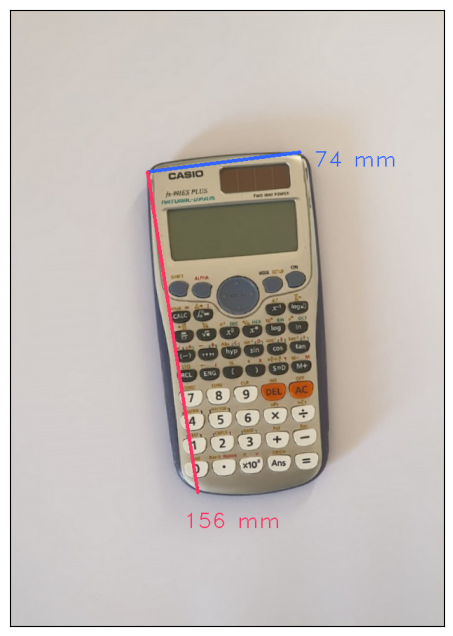

(881, 620, 3)


In [33]:
# Codeblock 18
def write_size(rect_coords_list, sizes, img_warped):
    
    img_result = img_warped.copy()
    
    for rect_coord, size in zip(rect_coords_list, sizes):
        
        top_left = rect_coord[0].astype(int)
        top_right = rect_coord[1].astype(int)
        bottom_left = rect_coord[2].astype(int)
        
        cv2.line(img_result, top_left, top_right, (255,100,50), 4)
        cv2.line(img_result, top_left, bottom_left, (100,50,255), 4)
        
        cv2.putText(img_result, f'{np.int32(size[0])} mm', 
                    (bottom_left[0]-20, bottom_left[1]+50), 
                    cv2.FONT_HERSHEY_DUPLEX, 1, (100,50,255), 1)

        cv2.putText(img_result, f'{np.int32(size[1])} mm', 
                    (top_right[0]+20, top_right[1]+20), 
                    cv2.FONT_HERSHEY_DUPLEX, 1, (255,100,50), 1)
    
    return img_result

img_result = write_size(rect_coords_list, sizes_mm, img_warped)  #1
show_image(img_result)
print(img_result.shape)

In [34]:
# Codeblock 19
def measure_size(path, img_original_scale=0.7,
                 PAPER_W=210, PAPER_H=297, SCALE=3, 
                 paper_eps_param=0.04, objects_eps_param=0.05,  
                 canny_thresh_1=57, canny_thresh_2=232):
    
    PAPER_W = PAPER_W * SCALE
    PAPER_H = PAPER_H * SCALE
    
    # Loading and preprocessing original image.
    img_original = load_image(path=path, scale=img_original_scale)
    img_preprocessed, img_each_step = preprocess_image(img_original, 
                                                       thresh_1=canny_thresh_1, 
                                                       thresh_2=canny_thresh_2)
    
    # Finding paper contours and corners.
    polygons, img_contours = find_contours(img_preprocessed, 
                                           img_original, 
                                           epsilon_param=paper_eps_param)
    
    # Reordering paper corners.
    rect_coords = np.float32(reorder_coords(polygons[0]))

    # Warping image according to paper contours.
    paper_coords = np.float32([[0,0], 
                               [PAPER_W,0], 
                               [0,PAPER_H],
                               [PAPER_W,PAPER_H]])
    img_warped = warp_image(rect_coords, paper_coords, img_original)
    
    # Preprocessing the warped image.
    img_warped_preprocessed, _ = preprocess_image(img_warped)
    
    # Finding contour in the warped image.
    polygons_warped, img_contours_warped = find_contours(img_warped_preprocessed, 
                                                         img_warped,
                                                         epsilon_param=objects_eps_param)
    
    # Edge langth calculation.
    sizes, rect_coords_list = calculate_sizes(polygons_warped)
    sizes_mm = convert_to_mm(sizes, img_warped)
    img_result = write_size(rect_coords_list, sizes_mm, img_warped)
    
    return img_result

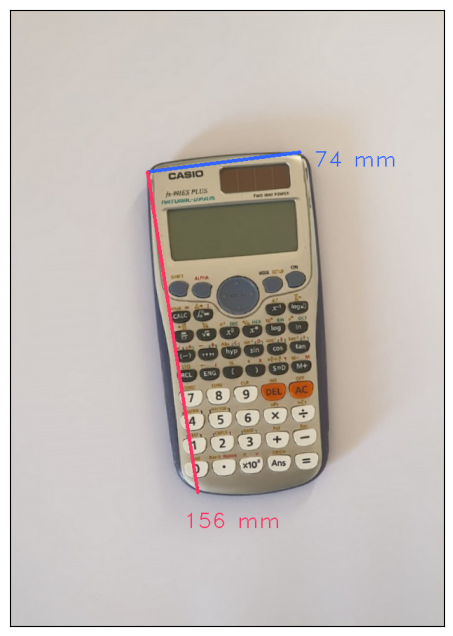

error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


In [ ]:
# Codeblock 20
show_image(measure_size('images/1.jpeg'))
show_image(measure_size('images/2.jpeg'))
show_image(measure_size('images/3.jpeg'))
show_image(measure_size('images/4.jpeg'))
show_image(measure_size('images/5.jpeg'))
show_image(measure_size('images/6.jpeg', objects_eps_param=0.1))